# <img src="./media_assets/pouring-water-logo5.png" alt="Logo" width="40"> The Sound of Water: Inferring Physical Properties from Pouring Liquids

This is a demo notebook associated with our paper published at XYZ.

We will walk you through how the model works and run it on a few samples. This is meant to be an educational resource to help you understand our paper.

<a target="_blank" href="https://colab.research.google.com/github/bpiyush/SoundOfWater/blob/main/playground.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import sys

# Setting PYTHONPATH to the current directory
sys.path.append(os.getcwd())

import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import decord
import PIL, PIL.Image
import librosa
from IPython.display import Markdown, display
import pandas as pd

import shared.utils as su
import sound_of_water.audio_pitch.model as audio_models
import sound_of_water.data.audio_loader as audio_loader
import sound_of_water.data.audio_transforms as at
import sound_of_water.data.csv_loader as csv_loader

## Table of Contents

* [Load and visualise data](#data)
* [The Physics of pouring water](#physics)
* [Pitch detection: Model inference](#pitch)
* [Physical properties from pitch](#physical-properties)
* [Does it generalise?](#generalise)
* [Citation](#citation)

## Load and visualise data <a class="anchor" id="data"></a>

First, we will load and visualise a video (with audio) of pouring water into a glass. 

In [2]:
# Load an example video path
video_path = "./media_assets/example_video.mp4"
metadata_path = "./media_assets/example_metadata.json"
assert os.path.exists(video_path), \
    f"Video file not found at {video_path}"
assert os.path.exists(metadata_path), \
    f"Metadata file not found at {metadata_path}"

metadata = su.io.load_json(metadata_path)
su.log.json_print(metadata)

{
    "video_id": "VID_20240116_230040",
    "start_time": 2.057,
    "end_time": 16.71059,
    "setting": "ws-kitchen",
    "bg-noise": "no",
    "water_temperature": "normal",
    "liquid": "water_normal",
    "container_id": "container_1",
    "flow_rate_appx": "constant",
    "comment": null,
    "clean": "yes",
    "time_annotation_mode": "manual",
    "shape": "cylindrical",
    "material": "plastic",
    "visibility": "transparent",
    "example_video_id": "VID_20240116_230040",
    "measurements": {
        "diameter_bottom": 5.7,
        "diameter_top": 6.3,
        "net_height": 19.7,
        "thickness": 0.32
    },
    "hyperparameters": {
        "beta": 0.0
    },
    "physical_parameters": null,
    "item_id": "VID_20240116_230040_2.1_16.7"
}


In [3]:
def define_axes(figsize=(13, 4), width_ratios=[0.22, 0.78]):
    fig, axes = plt.subplots(
        1, 2, figsize=figsize, width_ratios=width_ratios,
    )
    return fig, axes


def show_frame_and_spectrogram(frame, spectrogram, visualise_args, axes=None):
    """Shows the frame and spectrogram side by side."""

    if axes is None:
        fig, axes = define_axes()
    else:
        assert len(axes) == 2

    ax = axes[0]
    ax.imshow(frame, aspect="auto")
    ax.set_title("Example frame")
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axes[1]
    audio_loader.show_logmelspectrogram(
        S=spectrogram,
        ax=ax,
        show=False,
        sr=visualise_args["sr"],
        n_fft=visualise_args["n_fft"],
        hop_length=visualise_args["hop_length"],
    )


def scatter_pitch(ax, t, f, s=60, marker="o", color="limegreen", label="Pitch"):
    """Scatter plot of pitch."""
    ax.scatter(t, f, color=color, label=label, s=s, marker=marker)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.legend()

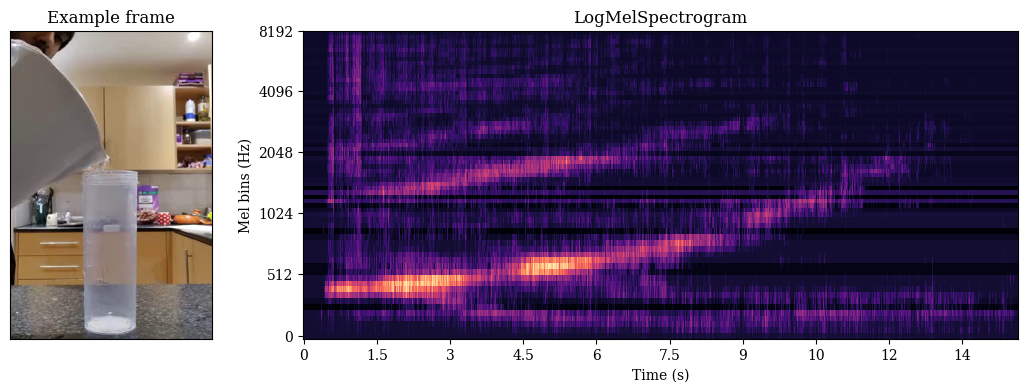

In [4]:
# Visualise the sample

# Load video frame
vr = decord.VideoReader(video_path, num_threads=1)
frame = PIL.Image.fromarray(vr[0].asnumpy())
frame = audio_loader.crop_or_pad_to_size(frame, size=(270, 480))


# Load audio
visualise_args = {
    "sr": 16000,
    "n_fft": 400,
    "hop_length": 320,
    "n_mels": 64,
    "margin": 16.,
    "C": 340 * 100.,
    "audio_output_fps": 49.,
    "w_max": 100.,
    "n_bins": 64,
}
aload_args = {
    "sr": 16000,
    "clip_len": None,
    "backend": "decord",
}
y = audio_loader.load_audio_clips(
    audio_path=video_path,
    clips=None,
    load_entire=True,
    cut_to_clip_len=False,
    **aload_args,
)[0]
S = audio_loader.librosa_harmonic_spectrogram_db(
    y,
    sr=visualise_args["sr"],
    n_fft=visualise_args["n_fft"],
    hop_length=visualise_args["hop_length"],
    n_mels=visualise_args['n_mels'],
)


show_frame_and_spectrogram(frame, S, visualise_args)

## The Physics of Liquid Pouring <a class="anchor" id="physics"></a>

In this section, we will demonstrate the physics behind liquid pouring. Specifically, a physical equation determines how the sound of pouring relates to how much water has been poured at a given time.

Let's assume we are pouring water in a cylindrical container with height $H$ and radius $R$. At time $t$, let $l(t)$ denote the length of air column in the container (difference between height of container and height of water). Then, the fundamental frequency (*pitch*) $f(t)$ of the sound produced by the water pouring is given by the equation:

$$
f(t) = \frac{c}{4}.\left( \frac{1}{l(t) + \beta R} \right),
$$

where $c$ is the speed of sound in air, $R$ is the radius of the container, and $\beta$ is a constant.

Let's try and visualise this equation by overlaying this theoretical pitch curve on a spectrogram.

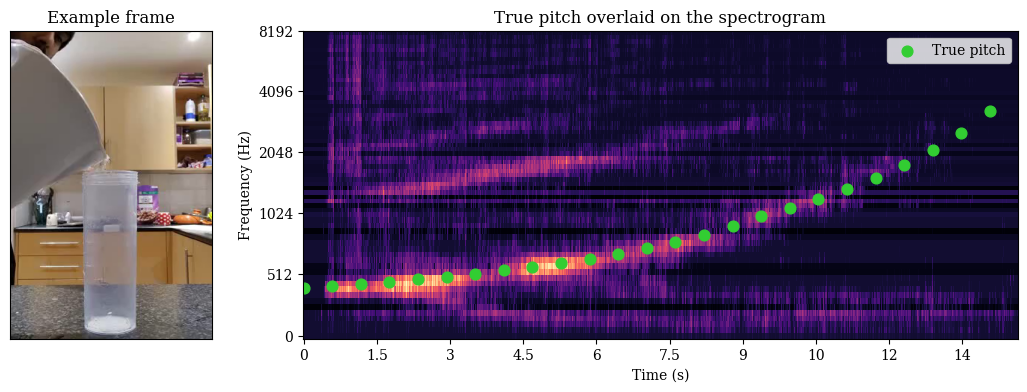

In [5]:
# First, let's compute this theorethical pitch

# Define the timestamps on which we shall compute the pitch
duration = (metadata["end_time"] - metadata["start_time"])
timestamps = np.linspace(0, duration, num=25, endpoint=False)

# Get true (theoretical) frequencies at these times
# Note that we require the measurements of the container
# which are stored in the metadata
params = su.physics.get_params(
    metadata, semiconical_as_cylinder=True,
)
f_true = su.physics.get_frequencies(
    t=timestamps,
    params=params,
    container_shape=metadata["shape"],
    harmonic=None,
    vibration_type="axial",
    semiconical_as_cylinder=True,
)
f_true = torch.from_numpy(f_true)


# Show the true pitch overlaid on the spectrogram
fig, axes = define_axes()
show_frame_and_spectrogram(frame, S, visualise_args, axes=axes)
scatter_pitch(axes[1], timestamps, f_true, color="limegreen", label="True pitch")
axes[1].set_title("True pitch overlaid on the spectrogram")
plt.show()


Why does this pitch $f(t)$ matter though? As we show in the paper, using this pitch, we can recover several useful physical properties of the container such as height, radius and volume flow rate. But that is for later. Next, we will show how our pitch detection model works on this sample.

## Pitch detection <a class="anchor" id="pitch"></a>

In this work, our main contribution is to train a pitch detection model in a novel way:

1. First, we pre-train it on synthetic sounds of pouring water.
2. Then, we fine-tune it on real-world sounds of pouring water. Since there is no ground truth label for real data, we make use of the visual stream for co-supervision.

Here, we will show how the model works on this example.

In [6]:
# First, let's load the model

cfg_backbone = {
    "name": "Wav2Vec2WithTimeEncoding",
    "args": dict(),
}
backbone = getattr(audio_models, cfg_backbone["name"])(
    **cfg_backbone["args"],
)


cfg_model = {
    "name": "WavelengthWithTime",
    "args": {
        "axial": True,
        "axial_bins": 64,
        "radial": True,
        "radial_bins": 64,
        "freeze_backbone": True,
        "train_backbone_modules": [6, 7, 8, 9, 10, 11],
        "act": "softmax",
        "criterion": "kl_div",
    }
}
model = getattr(audio_models, cfg_model["name"])(
    backbone=backbone, **cfg_model["args"],
)
su.misc.num_params(model)


# Load the model weights from trained checkpoint
# NOTE: Be sure to set the correct path to the checkpoint
su.log.print_update("[:::] Loading checkpoint ", color="cyan", fillchar=".")
ckpt_dir = "/work/piyush/pretrained_checkpoints/SoundOfWater"
ckpt_path = os.path.join(
    ckpt_dir, 
    "dsr9mf13_ep100_step12423_real_finetuned_with_cosupervision.pth",
)
assert os.path.exists(ckpt_path), \
    f"Checkpoint not found at {ckpt_path}."
print("Loading checkpoint from: ", ckpt_path)
ckpt = torch.load(ckpt_path, map_location="cpu")
msg = model.load_state_dict(ckpt)
print(msg)

 [:::] Loading backbone Wav2Vec 2.0 ..............................................................  


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 [:::] Loading model WavelengthWithTime ..........................................................  
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing Wav2Vec2EncoderLayer
[>>>] Unfreezing layer norm in backbone
::: Number of trainable parameters in Wav2Vec2WithTimeEncoding: 42.527 M
::: Number of trainable parameters in Identity: 0.0 M
::: Number of trainable parameters in Linear: 0.049 M
::: Number of trainable parameters in Linear: 0.049 M
::: Number of total parameters in WavelengthWithTime: 94.47M
................................... [:::] Loading checkpoint  ....................................
Loading checkpoint from:  /work/piyush/pretrained_checkpoints/SoundOfWater/dsr9mf13_ep100_step12423_real_finetuned_with_cosupervision.pth
<All keys matched successfully>


Now, let's run the model on this sample and visualise the pitch curve.

In [7]:
# Define audio transforms
cfg_transform = {
    "audio": {
        "wave": [
            {
                "name": "AddNoise",
                "args": {
                "noise_level": 0.001
                },
                "augmentation": True,
            },
            {
                "name": "ChangeVolume",
                "args": {
                "volume_factor": [0.8, 1.2]
                },
                "augmentation": True,
            },
            {
                "name": "Wav2Vec2WaveformProcessor",
                "args": {
                "model_name": "facebook/wav2vec2-base-960h",
                "sr": 16000
                }
            }
        ],
        "spec": None,
    }
}
audio_transform = at.define_audio_transforms(
    cfg_transform, augment=False,
)

# Define audio pipeline arguments
apipe_args = {
    "spec_args": None,
    "stack": True,
}

# Load and transform input audio
audio = audio_loader.load_and_process_audio(
    audio_path=video_path,
    clips=None,
    load_entire=True,
    cut_to_clip_len=False,
    audio_transform=audio_transform,
    aload_args=aload_args,
    apipe_args=apipe_args,
)[0]
w =  su.log.get_terminal_width()
print("." * w)
print("Input tensor shape: ", audio.shape)
print("." * w)


with torch.no_grad():
    NS = audio.shape[-1]
    duration = NS / 16000
    t = torch.tensor([[0, duration]]).unsqueeze(0)
    x = audio.unsqueeze(0)
    z_audio = model.backbone(x, t)[0][0].cpu()
    y_audio = model(x, t)["axial"][0][0].cpu()

print("Latent features shape: ", z_audio.shape)
print("." * w)

print("Output (wavelength distribution) shape: ", y_audio.shape)
print("." * w)

2024-11-16 16:47:40.652666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 16:47:40.860508: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 16:47:44.455107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/piyush/install/miniconda3/envs/py39-pt201/lib/python3.9/site-packages/cv2/../../l

................................................................................
Input tensor shape:  torch.Size([1, 1, 234496])
................................................................................
Latent features shape:  torch.Size([732, 768])
................................................................................
Output (wavelength distribution) shape:  torch.Size([732, 64])
................................................................................


Now, let's visualise the output overlayed on the spectrogram.

In [8]:
# Define the timestamps for evaluation
# NOTE: these timestamps are pre-defined
# since the model (`wav2vec2`) uses a fixed
# window size and stride
n_frames = len(y_audio)
timestamps_eval = librosa.frames_to_time(
    np.arange(n_frames),
    sr=visualise_args['sr'],
    n_fft=visualise_args['n_fft'],
    hop_length=visualise_args['hop_length'],
)
timestamps_eval

# Get predicted frequencies at these times
wavelengths = y_audio @ torch.linspace(
    0, visualise_args['w_max'], visualise_args['n_bins'],
)
f_pred = visualise_args['C'] / wavelengths


# Pick only those timestamps where we define the true pitch
indices = su.misc.find_nearest_indices(timestamps_eval, timestamps)
# timestamps_eval = timestamps_eval[indices]
f_pred = f_pred[indices]

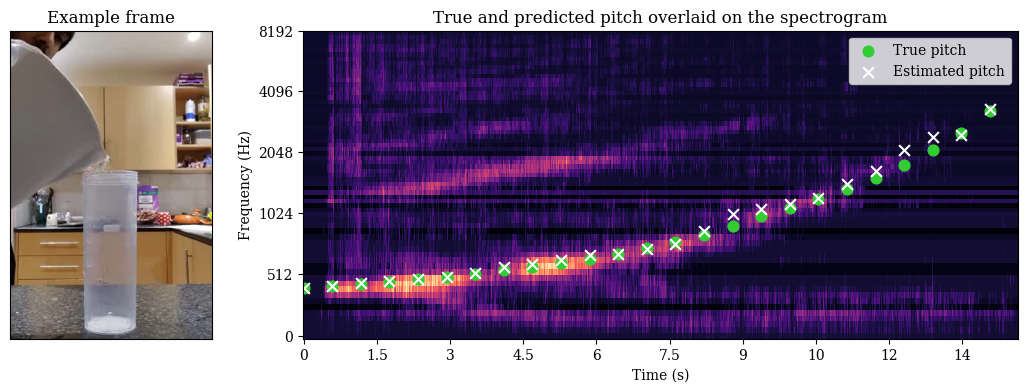

In [9]:
# Show the true/pref pitch overlaid on the spectrogram
fig, axes = define_axes()
show_frame_and_spectrogram(frame, S, visualise_args, axes=axes)
scatter_pitch(axes[1], timestamps, f_true, color="limegreen", label="True pitch")
scatter_pitch(axes[1], timestamps, f_pred, color="white", label="Estimated pitch", marker="x")
axes[1].set_title("True and predicted pitch overlaid on the spectrogram")
plt.show()

As you can see, the estimated pitch curve closely follows the theoretical pitch curve. Let's also look at the learned latent representation of the audio to get better intuition.

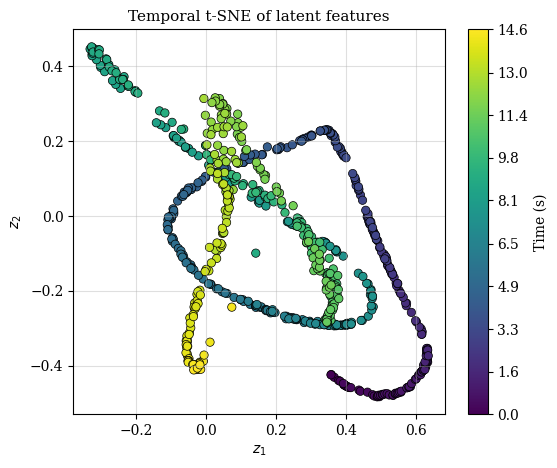

In [10]:
su.visualize.show_temporal_tsne(
    z_audio.detach().numpy(), timestamps_eval, show=False,
    figsize=(6, 5), title="Temporal t-SNE of latent features",
)

It seems that the representations seem to be on a manifold where vectors are predictably changing over time $t$. In the paper, we also show that these representations encode interesting physical properties such as mass of the liquid poured and shape of the container.

## Physical properties from pitch <a class="anchor" id="physical-properties"></a>

Now that we have an estimate of the pitch, we can recover physical properties of the container. Please see the paper for detailed derivation.

In [11]:
# Get physical properties
l_pred = su.physics.estimate_length_of_air_column(wavelengths)
l_pred_mean = l_pred.mean()
H_pred = su.physics.estimate_cylinder_height(wavelengths)
R_pred = su.physics.estimate_cylinder_radius(wavelengths)

# Get ground truth length
# timestamps = np.linspace(0., duration, len(wavelengths))
l_true = su.physics.get_length_of_air_column(
    metadata["measurements"], duration, timestamps_eval,
)
l_true_mean = l_true.mean()

# Get ground truth height
H_true = su.physics.get_cylinder_height(metadata["measurements"])

# Get ground truth radius
R_true = su.physics.get_cylinder_radius(metadata["measurements"])

# Create a dataframe to visualise the errors
df_show = pd.DataFrame(
    {
        "Property": ["Height", "Radius", "Length (mean)"],
        "True Value": [H_true, R_true, l_true_mean.item()],
        "Estimated Value": [H_pred, R_pred, l_pred_mean.item()],
        "Error": [
            np.abs(H_true - H_pred).item(),
            np.abs(R_true - R_pred).item(),
            np.abs(l_true_mean - l_pred_mean).item()
        ],
    }
)
# Round off the values
df_show = df_show.applymap(lambda x: np.round(x, 2) if isinstance(x, (int, float)) else x)
display(df_show)

display(Markdown("**Note:** All values are in cms."))

,Property,True Value,Estimated Value,Error
0,Height,19.70,19.24,0.46
1,Radius,3.00,3.69,0.69
2,Length (mean),9.86,8.94,0.92


**Note:** All values are in cms.

Voila! It can estimate the height of container with < 0.5 cm error and radius by < 0.7cm error.

## Does it generalise? <a class="anchor" id="generalise"></a>

We test it on a sample from YouTube. Ofcourse, we do not have ground truth estimates of the container. But we can at least look at the predictions.

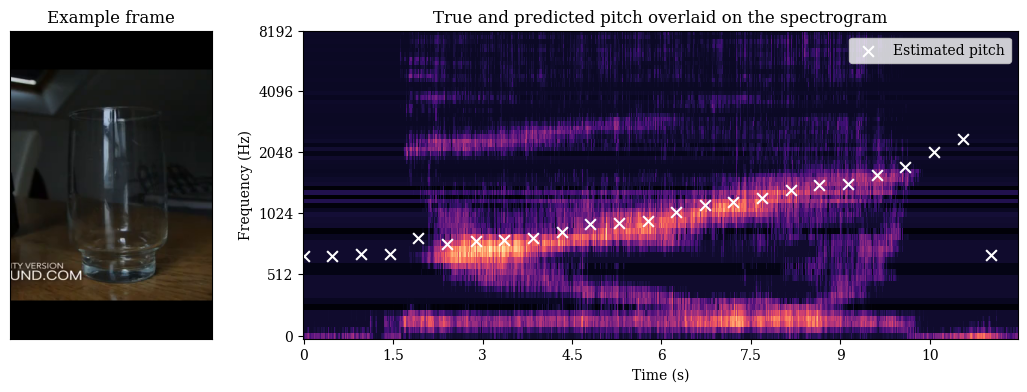

In [15]:
# Path to the video
video_path = "./media_assets/ayNzH0uygFw_9.0_21.0.mp4"

# Load video frame
vr = decord.VideoReader(video_path, num_threads=1)
duration = len(vr) / vr.get_avg_fps()
timestamps = np.linspace(0, duration, num=25, endpoint=False)
frame = PIL.Image.fromarray(vr[0].asnumpy())
frame = audio_loader.crop_or_pad_to_size(frame, size=(270, 480))


y = audio_loader.load_audio_clips(
    audio_path=video_path,
    clips=None,
    load_entire=True,
    cut_to_clip_len=False,
    **aload_args,
)[0]
S = audio_loader.librosa_harmonic_spectrogram_db(
    y,
    sr=visualise_args["sr"],
    n_fft=visualise_args["n_fft"],
    hop_length=visualise_args["hop_length"],
    n_mels=visualise_args['n_mels'],
)


# Load and transform input audio
audio = audio_loader.load_and_process_audio(
    audio_path=video_path,
    clips=None,
    load_entire=True,
    cut_to_clip_len=False,
    audio_transform=audio_transform,
    aload_args=aload_args,
    apipe_args=apipe_args,
)[0]

# Run inference
with torch.no_grad():
    NS = audio.shape[-1]
    duration = NS / 16000
    t = torch.tensor([[0, duration]]).unsqueeze(0)
    x = audio.unsqueeze(0)
    z_audio = model.backbone(x, t)[0][0].cpu()
    y_audio = model(x, t)["axial"][0][0].cpu()

# Timestamps for evaluation
n_frames = len(y_audio)
timestamps_eval = librosa.frames_to_time(
    np.arange(n_frames),
    sr=visualise_args['sr'],
    n_fft=visualise_args['n_fft'],
    hop_length=visualise_args['hop_length'],
)
timestamps_eval

# Get predicted frequencies at these times
wavelengths = y_audio @ torch.linspace(
    0, visualise_args['w_max'], visualise_args['n_bins'],
)
f_pred = visualise_args['C'] / wavelengths

# Pick only those timestamps where we define the true pitch
indices = su.misc.find_nearest_indices(timestamps_eval, timestamps)
f_pred = f_pred[indices]


# Show the true/pref pitch overlaid on the spectrogram
fig, axes = define_axes()
show_frame_and_spectrogram(frame, S, visualise_args, axes=axes)
scatter_pitch(axes[1], timestamps, f_pred, color="white", label="Estimated pitch", marker="x")
axes[1].set_title("True and predicted pitch overlaid on the spectrogram")
plt.show()

Notice how it is quite reasonable until towardas the end. We hypothesise that this due to very low signal towards the end of the audio.

In [20]:
# Get physical properties
l_pred = su.physics.estimate_length_of_air_column(wavelengths)
l_pred_mean = l_pred.mean().item()
l_pred_mean = np.round(l_pred_mean, 2)
H_pred = su.physics.estimate_cylinder_height(wavelengths)
H_pred = np.round(H_pred, 2)
R_pred = su.physics.estimate_cylinder_radius(wavelengths)
R_pred = np.round(R_pred, 2)

df_show = pd.DataFrame({
    "Property": ["Height", "Radius", "Length (mean)"],
    "Estimated Value (in cms)": [H_pred, R_pred, l_pred_mean],
})
display(df_show)

,Property,Estimated Value (in cms)
0,Height,9.24
1,Radius,5.86
2,Length (mean),5.21


## Citation <a class="anchor" id="citation"></a>

If you found this interesting, please consider giving a ⭐️ on Github. If this relates to your research, please cite us:

```bibtex
@article{sound_of_water_bagad,
  title={The Sound of Water: Inferring Physical Properties from Pouring Liquids},
  author={Bagad, Piyush and Tapaswi, Makarand and Snoek, Cees G. M. and Zisserman, Andrew},
  journal={arXiv},
  year={2024}
}
```